# Predicting Heart Disease 

This project intends to use a proprietary hospital dataset alongside a machine learning classifier model (KNN) to predict the incidence of heart disease. 

## Investigation

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

heart_df = pd.read_csv('heart_disease_prediction.csv')
heart_df.head(5)



,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [21]:
print(heart_df.shape)

(918, 12)


In [22]:
print(heart_df.dtypes)

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object


### Numerical Columns

In [23]:
heart_df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [24]:
print(heart_df.isnull().sum())

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


Based on the above statistical summary, a few preliminary observations are worth making. 

1. The average age of the patients is 53, with the minimum age being 28. 
2. The average `RestingBP` seems a little high, as does the average `Cholestrol`, both likely a product of skewness due to outliers. Also, curiously, `RestingBP` and `Cholestrol` have minimums of zero.  
3. There do not appear to be any missing values in the entire dataset.  

### Categorical Columns

In [25]:
cate = list(heart_df.select_dtypes(include='object').columns)
extra = ['HeartDisease', 'FastingBS']
cate.extend(extra)

print(cate)

['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'HeartDisease', 'FastingBS']


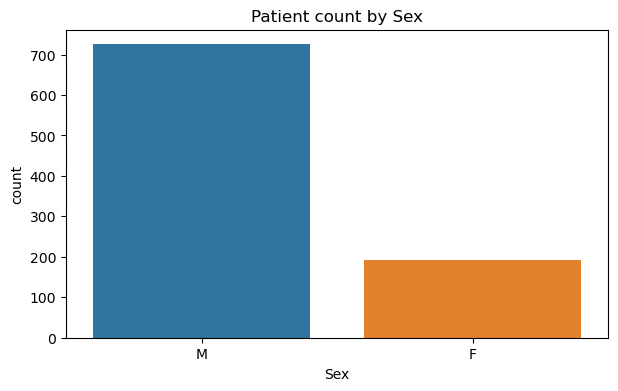

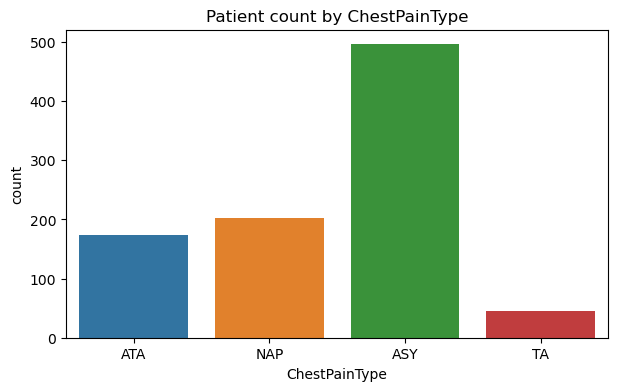

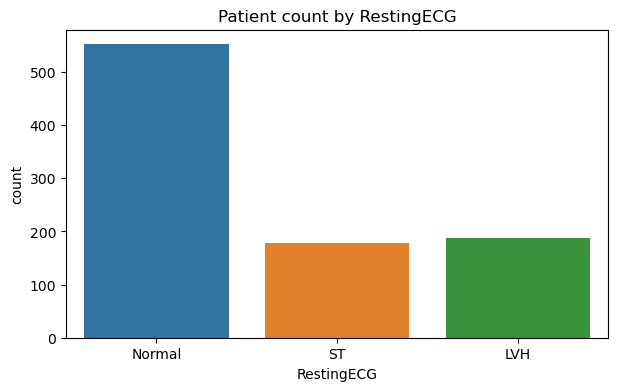

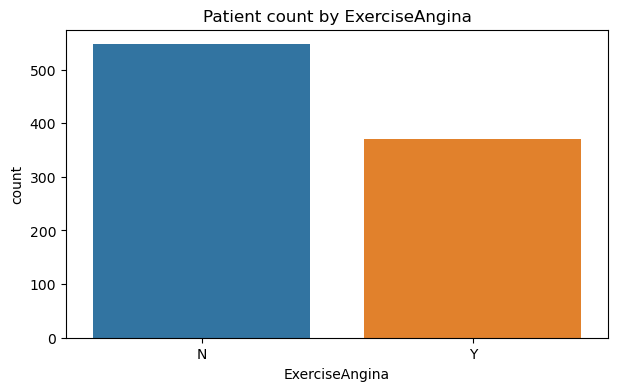

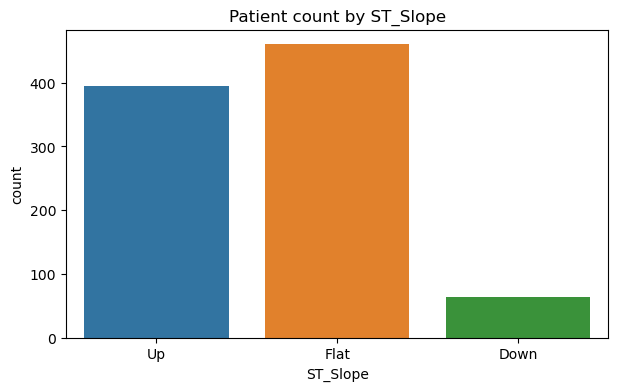

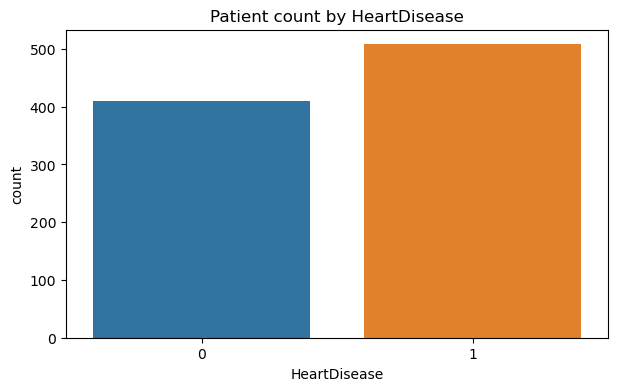

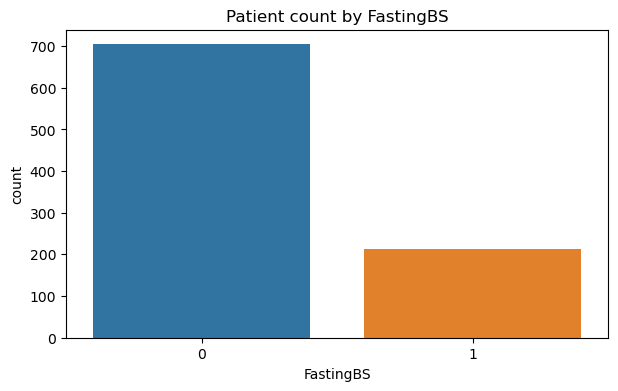

In [26]:
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
%matplotlib inline 

#creating bar chart for each categorical column that displays number of rows for each category
#can use value_counts, but seaborn has a countplot... lets try it out

for col in cate: 
    
    #setting up figure, using pyplot style of plotting so will automatically track figs and axes
    plt.figure(figsize=(7,4))
    sns.countplot(data=heart_df, x=col)
    plt.title(f'Patient count by {col}')
    plt.xlabel(col)
    plt.ylabel('count')
    plt.show()          

    

In [27]:
#we can still print out the value counts separatley...

for col in cate: 
    
    counts = heart_df[col].value_counts()
    counts = pd.DataFrame(counts)
    print(counts)

   Sex
M  725
F  193
     ChestPainType
ASY            496
NAP            203
ATA            173
TA              46
        RestingECG
Normal         552
LVH            188
ST             178
   ExerciseAngina
N             547
Y             371
      ST_Slope
Flat       460
Up         395
Down        63
   HeartDisease
1           508
0           410
   FastingBS
0        704
1        214


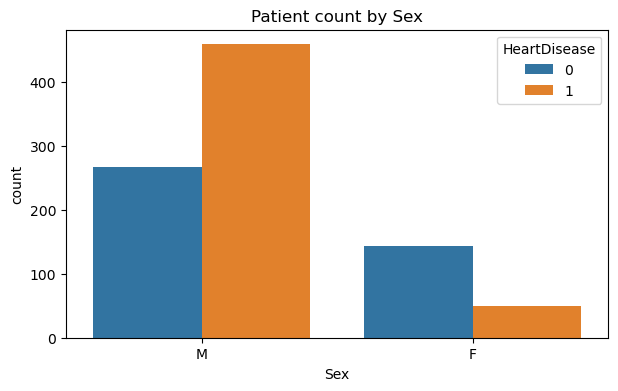

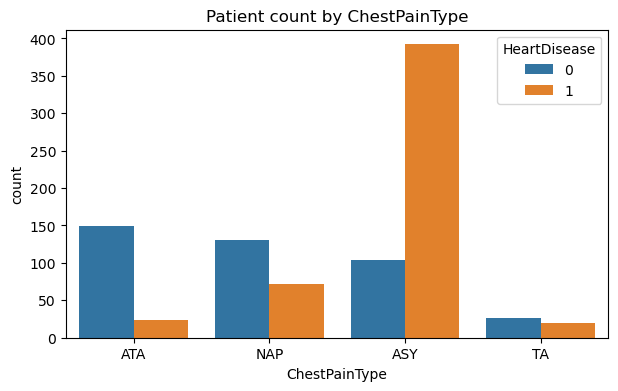

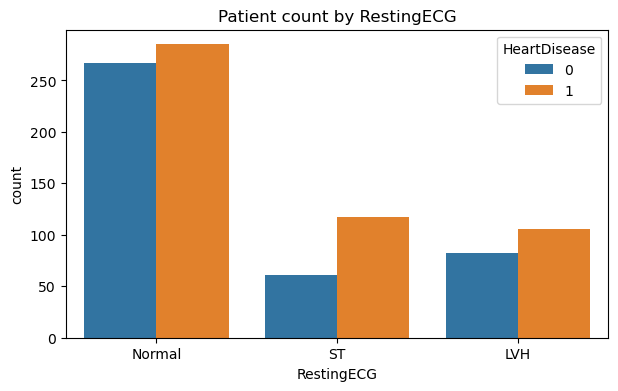

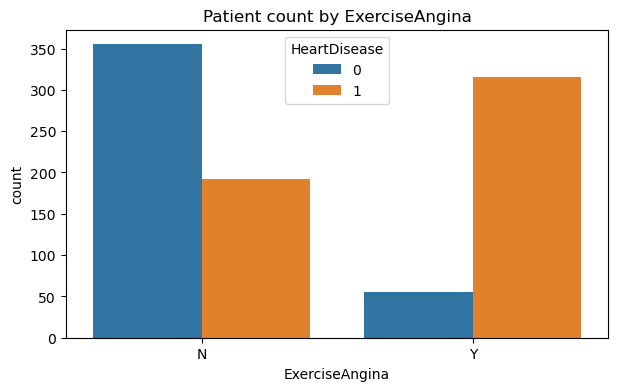

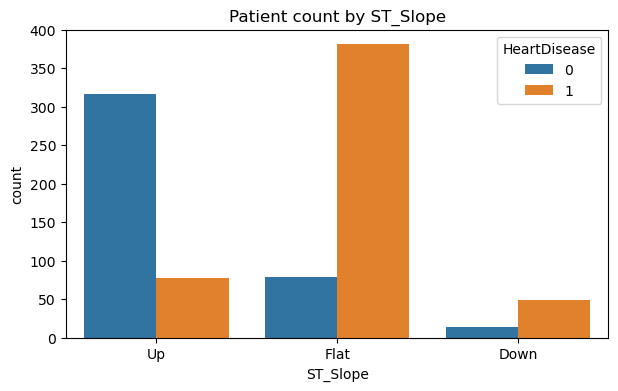

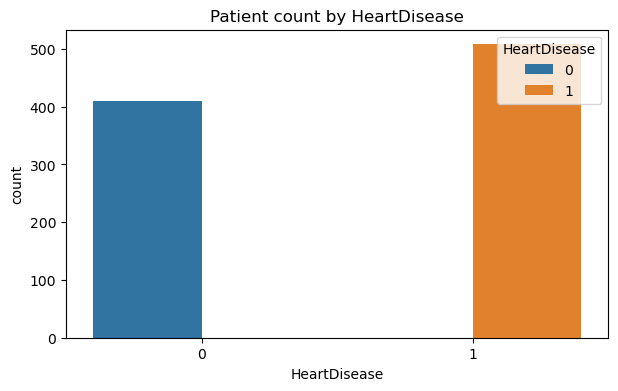

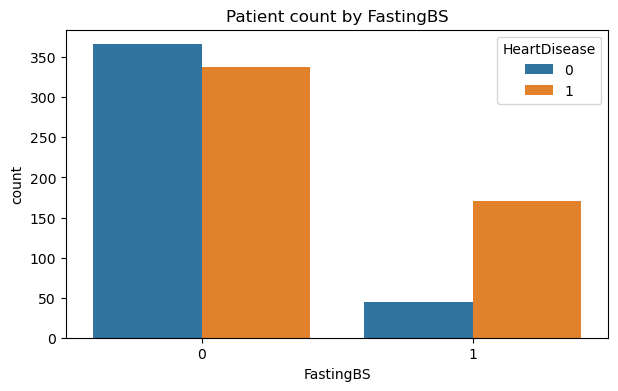

In [28]:
#creating bar chart for each cate col that displays number of rows for each cate of the column 
#this time grouped by HeartDisease

for col in cate: 
    
    plt.figure(figsize=(7,4))
    sns.countplot(data=heart_df, x=col, hue='HeartDisease')
    plt.title(f'Patient count by {col}')
    plt.xlabel(col)
    plt.ylabel('count')
    plt.show()  

From the above grouped bar graphs, a few observations are worth making: 

1. Among patients with heart disease, considerably more patients report ASY type chest pain than other types. 
2. A substantial amount more patients with heart disease present with a flat ST slope.
3. There appear to be many more male patients with heart disease present in this dataset than females with heart disease. There are also more males with heart disease than males without heart disease. 
4. Our target variable, `HeartDisease` appears to be evenly distributed, a good sign for when we build our model. 
5. Patients with heart disease appear to disproportionately present with a blood sugar above 120 mg/dl

## Cleaning

We identified earlier that there are some values within the columns that do not make sense upon a domain knowledge evaluation. Let's clean these up so that our model is as accurate as possible. 

In [29]:
#lets remove the zero rows from the relevant columns we discussed

missing_RBP = heart_df[heart_df['RestingBP'] == 0]['RestingBP']
missing_CHOL = heart_df[heart_df['Cholesterol'] == 0]['Cholesterol']

print(missing_RBP.count(), missing_CHOL.count())

1 172


In [30]:
#we have one and 172 0 values in each row... lets drop those

heart_df.drop(heart_df[heart_df['RestingBP'] == 0].index, inplace=True)
heart_df.drop(heart_df[heart_df['Cholesterol'] == 0].index, inplace=True)

In [31]:
#checking 
heart_df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

## Feature Selection

It's now time to start identifying the features that we'd like to use in our model. To choose, we must use a combination of domain knowledge and analysis. 

In [32]:
#converting our categorical features into dummies for use in our model 

cate = list(heart_df.select_dtypes(include='object').columns)
heart_df = pd.get_dummies(data = heart_df, columns=cate)
print(heart_df.dtypes)



Age                    int64
RestingBP              int64
Cholesterol            int64
FastingBS              int64
MaxHR                  int64
Oldpeak              float64
HeartDisease           int64
Sex_F                  uint8
Sex_M                  uint8
ChestPainType_ASY      uint8
ChestPainType_ATA      uint8
ChestPainType_NAP      uint8
ChestPainType_TA       uint8
RestingECG_LVH         uint8
RestingECG_Normal      uint8
RestingECG_ST          uint8
ExerciseAngina_N       uint8
ExerciseAngina_Y       uint8
ST_Slope_Down          uint8
ST_Slope_Flat          uint8
ST_Slope_Up            uint8
dtype: object


<AxesSubplot:>

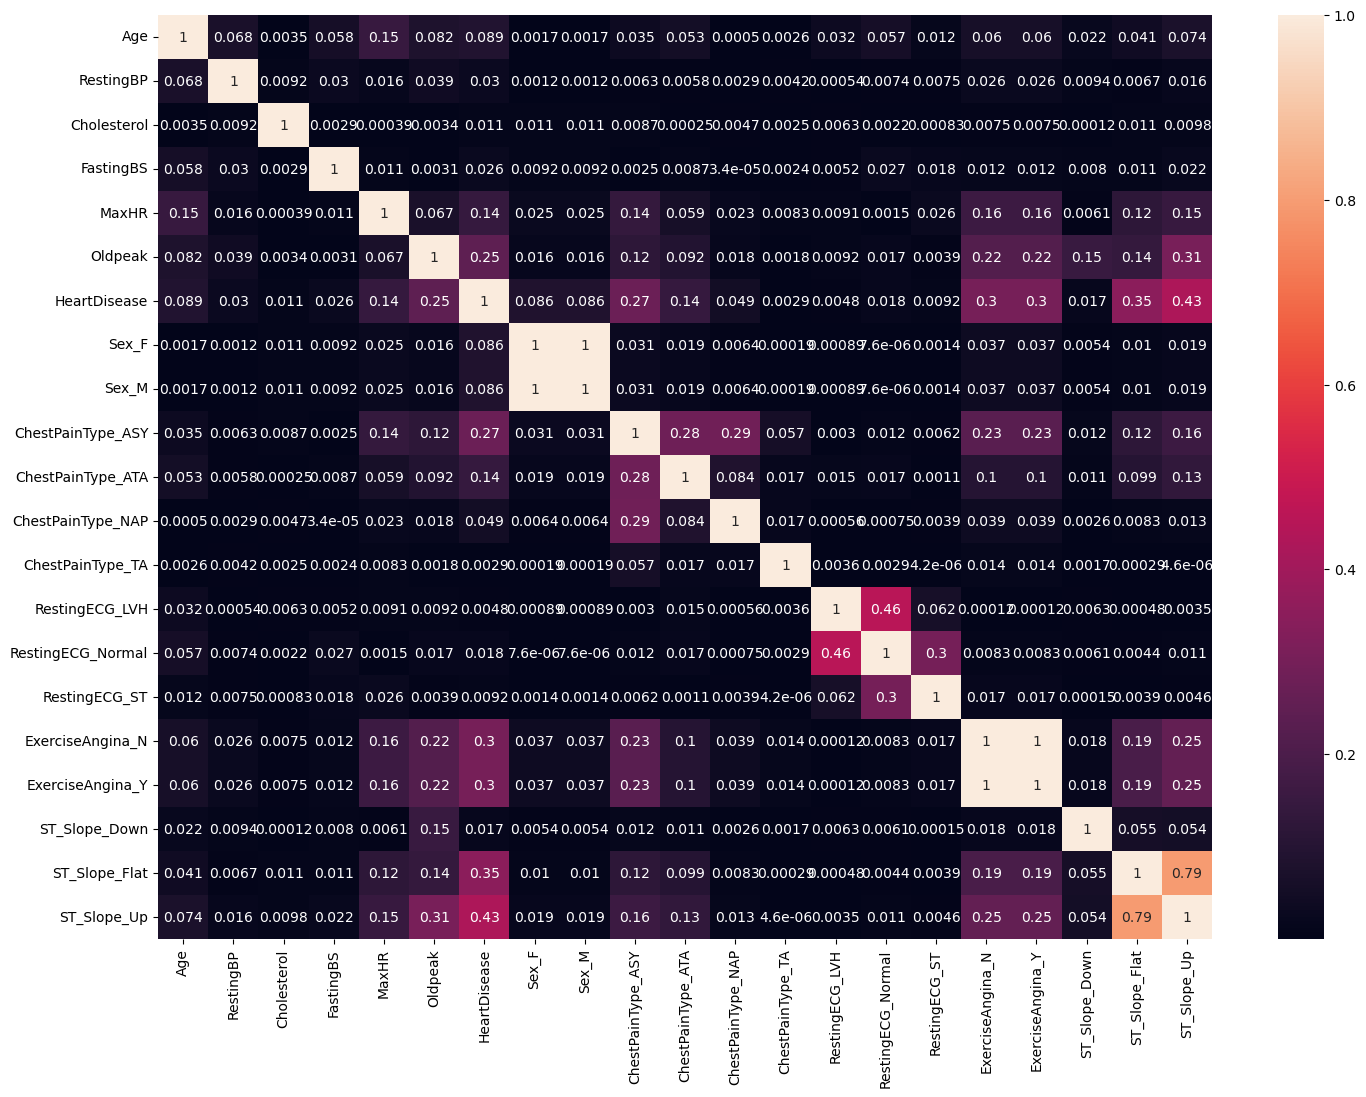

In [33]:
plt.figure(figsize=(17,12))
#using coeff of determination R^2 to determine which features to use
sns.heatmap((heart_df.corr()**2), annot=True)

Here we enlist the coeff of determination R^2 to identify which features we should use in our classification model. Naturally, this method has limitations, and there exists a solid argument for instead using the adj. R^2. 

One can read more on the latter here: https://www.datascienceblog.net/post/machine-learning/performance-measures-feature-selection/

## Constructing the Classifier

From the above investigation, it's clear we should move forward with the following features: 

* `Oldpeak`  

* `Sex_M` - Not a great value for R^2, but we identified this as being an important variable earlier given its lionshare of the sample, so we'll include it. 

* `ExerciseAngina_Y` 

* `ST_Slope_Flat` 

* `ST_Slope_Up`

Below, we begin the model building and training process. 

In [38]:
#split data
y = heart_df['HeartDisease'] 
X =  heart_df.drop('HeartDisease', axis=1)

#validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2, random_state = 10)
#validation and training set
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = .2*X.shape[0]/X_train.shape[0], random_state = 10) 

#chosen features
feats = ['Oldpeak', 'Sex_M', 'ExerciseAngina_Y', 'ST_Slope_Flat', 'ST_Slope_Up']

In [46]:
#building the classifier (without data normalization)

for feat in feats:
    #instantiating classifier for each iteration
    knn = KNeighborsClassifier(n_neighbors=5)
    #fitting model 
    knn.fit(X_train[[feat]], y_train)
    #evaluating model on validation set
    accuracy = knn.score(X_val[[feat]], y_val)
    print(f'{feat}: {accuracy.round(2)}')
    

Oldpeak: 0.75
Sex_M: 0.51
ExerciseAngina_Y: 0.76
ST_Slope_Flat: 0.79
ST_Slope_Up: 0.85


Based on the above preliminary evaluation, the model fit with the sole feature `ST_Slope_Up` performed the best. Recall, `ST_Slope_Up` describes the slope of the peak exercise ST segment on an ECG. 

In [45]:
#retrain a model with all features together

#normalizing features
scaler=MinMaxScaler()

#scaling
X_train_scaled = scaler.fit_transform(X_train[feats])
X_val_scaled = scaler.transform(X_val[feats])

#building model
knn = KNeighborsClassifier(n_neighbors=5)
#fitting model
knn.fit(X_train_scaled, y_train)
#validating model
accuracy = knn.score(X_val_scaled, y_val) 
print(f'Model Accuracy: {accuracy.round(2)}')


Model Accuracy: 0.81


The above blended model appears to perform worse on our validation set than the single feature model trained on `ST_Slope_UP`. Let's use this as a starting point for parameter and hyperparameter tuning, and see if we cannot achieve a better result.

In [55]:
#splitting data into training and test set 
#GridSearchCV automatically evaluates models on validation sets it creates from existing training data

#splitting training/testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.2, random_state=10)

#scaling 
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

#listing params for GridSearch
params = {'n_neighbors':range(1,10), 
         'metric': ['minkowski', 'manhattan'], 
         }

#instantiating knn model
knn = KNeighborsClassifier()

#creating GridSearchCV instance using instantiated model and params list
grid = GridSearchCV(knn, params, scoring='accuracy')
#fitting grid search instance to scaled training data... conducts validation automatically
grid.fit(X_train_scaled, y_train) 

#accessing best score
best_score = grid.best_score_
#accessing best model
best_model = grid.best_estimator_
#accessing best parameters
best_params = grid.best_params_

print(f'{best_model}: {best_score.round(2)}')
print(best_params)


KNeighborsClassifier(n_neighbors=7): 0.85
{'metric': 'minkowski', 'n_neighbors': 7}


From the above model with the chosen 5 features and hyperparameters, we achieved 85% accuracy. This is still a similar result to the model that was fit using only `ST_Slope_Up`. However, it is important to consider the fact that, becasue `GridSearchCV` employs cross-validation, these results are probably more robust than our single parameter model, despite the score discrepancy.  

Below is a short explanation on the best parameters: 

* Metric: This parameter sets the metric used for distance calculation within the model. In our case, the metric that produced the best result was the minkowski distance metric. 

* n_neighbors: This parameter stipulates the number of neighbors used in each iteration of our KNN model. The metric that produced the best result was 7 neighbors.

In [54]:
#eval model on our test set

#scaling 
X_test_scaled = scaler.transform(X_test)

#accessing best estimator
estimator = grid.best_estimator_

#eval on test set
accuracy = estimator.score(X_test_scaled, y_test)
print(f'Test Set Accuracy: {accuracy.round(2)}')

Test Set Accuracy: 0.86


The model appears to have performed better on the test set than it did in validation. Two possible explanations for the latter have been listed below:

* Differences in size between the testing and training sets. If the train-test split percentage is too uneven, it's understandable that the model will perform better on a less generalized dataset. 
* The uneven composition of our data, chiefly the `Sex` feature, may have reinforced our results. This is to say, assuming our model was trained on data that consisted of more male entries, if the testing data also has a small number of female entries, then our results should reflect that bias. 

## Conclusions

### Performance Improvments  

This model appears to be a good place to start the refinement process, but it is not quite at the level it needs to be for deployment. To improve performance one might consider the following:

**Suggestions for Improvement**
* Feature extraction: One might find that looking deeper into which features were selected for the model, and making the requisite changes, might improve predictive performance. 
* Hyperparameter Tuning: Considering different values for K and alternative distance metrics may result in improved accuracy. 





### Real-World Deployment 

Additionally, below is a list of pro's and con's relative to deploying this kind of classification model in a real-world healthcare setting:

**Pros**
* Simple Implementation: Not necessary to build a model and tune parameters in same way one might for others. 
* No linearity requirement: KNN's do not make assumptions about the underlying data.  

**Cons**
* Cost of Computation: Costs of compute are high because KNN does not have a training phase. Instead it stores the data during training and performs calculations upon querying the dataset. 
* Slow prediction: given high N (i.e. the number of samples in the training dataset), KNN's struggle to produce fast results.  


### Final Words

Ultimately, this model, like any model, has its strengths and weaknesses. That said, there do exist specific use cases, like identifying data-point cluster affiliation in data mining, for which KNN's are particularly well suited. As such, one should try and play to the advantages of this model where one can. 